In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt


html = requests.get('https://dadescovid.cat/diari')
soup = BeautifulSoup(html.text, 'html.parser')

table = soup.find('table', class_='table center')
body = soup.find('tbody')


# Extracció dels títols i dades de la web (web scraping)
def web_scraping_covid(table):
    """
    Crear una llista dels títols de la web
    Crear varies llistes amb les dades
    Obtenim un dataframe amb els títols i les dades

    Args:
        table: (:obj: `html`) : html
    Returns:
        df_covid (:obj: `df`) : dataframe
    """
    titles = []
    for i in table.find_all('th'):
        title = i.text.strip()
        titles.append(title)

    # Creem un df i posem nom a les columnes
    df_covid = pd.DataFrame(columns=titles)

    for idx, row in enumerate(body.find_all('tr')):  # genera una llista per cada fila
        fila = []
        for element in row.find_all('td'):  # genera els elements de cada fila
            elem = element.text.strip()
            fila.append(elem)
        df_covid.loc[idx] = fila  # afegim files al dataframe

    return df_covid


df_covid = web_scraping_covid(table)
df_covid

,Data,Casos confirmats per PCR/TA,PCR Fetes,TA Fets,% PCR/TA Positives,Vacunats 1a dosi,Vacunats 2a dosi,Ingressats,Defuncions
0,08/04/2021*,698,4.063,4.645,"6,96",59.361,3.061,1.695,0
1,07/04/2021*,1.644,20.691,7.593,"7,15",80.726,4.369,1.721,19
2,06/04/2021*,2.255,20.780,10.205,"8,34",46.243,2.264,1.726,21
3,05/04/2021,761,5.210,3.165,"9,31",17.414,7,1.721,16
4,04/04/2021,740,5.418,2.827,"10,01",12.592,3,1.617,13
...,...,...,...,...,...,...,...,...,...
399,05/03/2020,18,37,1,"13,89",0,0,0,0
400,04/03/2020,7,29,0,"3,45",0,0,0,0
401,03/03/2020,9,25,0,0,0,0,0,0
402,02/03/2020,5,35,1,"8,33",0,0,0,0


In [3]:
def calc_df_covid(df_covid):
    """
    Fer les modificacions necessàries per netejar i deixar
    operatiu el dataframe definitiu.
    Creació d'un fitxer csv amb les dades.

    Args:
        df_covid: (:obj: `df`) : dataframe
    Returns:
        df_cl (:obj: `df`) : dataframe
    """
    # Ordenem d'antic a més nou perquè faci els càlculs correctes
    df_covid=df_covid.loc[::-1].reset_index(drop=True)
    # Eliminem asterisc a Data, convertim la resta de variables a enters (eliminant el punt),
    # excepte % PCR/TA Positives que la passem a real (substituim coma per punt).
    df_covid['Data'] = df_covid['Data'].str.replace('\*', '')
    df_covid['Casos confirmats per PCR/TA'] = df_covid['Casos confirmats per PCR/TA'].str.replace('\.', '').astype(int)
    df_covid['PCR Fetes'] = df_covid['PCR Fetes'].str.replace('\.', '').astype(int)
    df_covid['TA Fets'] = df_covid['TA Fets'].str.replace('\.', '').astype(int)
    df_covid['% PCR/TA Positives'] = df_covid['% PCR/TA Positives'].str.replace('\,', '.').astype(float)
    df_covid['Vacunats 1a dosi'] = df_covid['Vacunats 1a dosi'].str.replace('\.', '').astype(int)
    df_covid['Vacunats 2a dosi'] = df_covid['Vacunats 2a dosi'].str.replace('\.', '').astype(int)
    df_covid['Ingressats'] = df_covid['Ingressats'].str.replace('\.', '').astype(int)
    df_covid['Defuncions'] = df_covid['Defuncions'].str.replace('\.', '').astype(int)

    for index, row in df_covid.iterrows():
        # Calculem la diferència
        df_covid['Canvi_diari'] = df_covid['Casos confirmats per PCR/TA'].diff()  # diferència diària
        df_covid['Canvi_7D'] = df_covid['Casos confirmats per PCR/TA'].diff(7)  # diferència 7 dies
        # Calculem el % d'increment o disminució
        df_covid['Canvi_%'] = df_covid['Casos confirmats per PCR/TA'].pct_change()
        df_covid['Canvi_7D_%'] = df_covid['Casos confirmats per PCR/TA'].pct_change(7)
        # Mitjana aritmètica mòbil
        df_covid['MA_7'] = df_covid['Casos confirmats per PCR/TA'].rolling(window=7).mean()  # Dels 7 últims dies
        df_covid['MA_30'] = df_covid['Casos confirmats per PCR/TA'].rolling(window=30).mean()  # Dels 30

    # Substituïm N/A per 0 (així podem canviar el type)
    df_covid = df_covid.fillna(0)
    # Canviem el type
    df_covid['Canvi_diari'] = df_covid['Canvi_diari'].astype('int64')
    df_covid['Canvi_7D'] = df_covid['Canvi_7D'].astype('int64')
    df_covid['Canvi_%'] = df_covid['Canvi_%'].astype('float64')
    df_covid['Canvi_7D_%'] = df_covid['Canvi_7D_%'].astype('float64')
    df_covid['MA_7'] = df_covid['MA_7'].astype('float64')
    df_covid['MA_30'] = df_covid['MA_30'].astype('float64')
    # Arrodonim a dos decimals
    df_covid['MA_7'] = round(df_covid['MA_7'].astype('float64'), 2)
    df_covid['MA_30'] = round(df_covid['MA_30'].astype('float64'), 2)
    df_covid['Canvi_%'] = round(df_covid['Canvi_%'].astype('float64'), 2)
    df_covid['Canvi_7D_%'] = round(df_covid['Canvi_7D_%'].astype('float64'), 2)
    # Creació fitxer csv
    df_covid.to_csv("evolucio_covid_a_catalunya.csv", index=False)
    # Canviem el format de la variable 'Data' a data
    df_covid['Data'] = [dt.datetime.strptime(d, '%d/%m/%Y').date() for d in df_covid['Data']]

    return df_covid


df_covid = calc_df_covid(df_covid)
df_covid

,Data,Casos confirmats per PCR/TA,PCR Fetes,TA Fets,% PCR/TA Positives,Vacunats 1a dosi,Vacunats 2a dosi,Ingressats,Defuncions,Canvi_diari,Canvi_7D,Canvi_%,Canvi_7D_%,MA_7,MA_30
0,2020-03-01,2,22,0,0.00,0,0,0,0,0,0,0.00,0.00,0.00,0.00
1,2020-03-02,5,35,1,8.33,0,0,0,0,3,0,1.50,0.00,0.00,0.00
2,2020-03-03,9,25,0,0.00,0,0,0,0,4,0,0.80,0.00,0.00,0.00
3,2020-03-04,7,29,0,3.45,0,0,0,0,-2,0,-0.22,0.00,0.00,0.00
4,2020-03-05,18,37,1,13.89,0,0,0,0,11,0,1.57,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,2021-04-04,740,5418,2827,10.01,12592,3,1617,13,-111,95,-0.13,0.15,1301.29,1189.97
400,2021-04-05,761,5210,3165,9.31,17414,7,1721,16,21,-1240,0.03,-0.62,1124.14,1196.13
401,2021-04-06,2255,20780,10205,8.34,46243,2264,1726,21,1494,529,1.96,0.31,1199.71,1255.30
402,2021-04-07,1644,20691,7593,7.15,80726,4369,1721,19,-611,6,-0.27,0.00,1200.57,1261.43


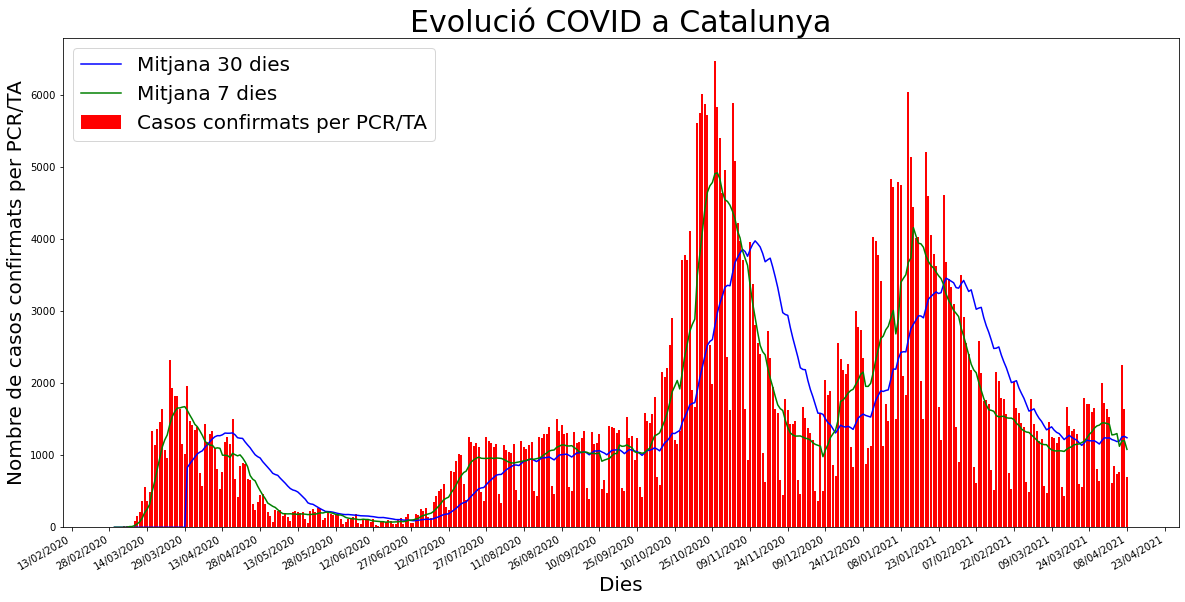

In [4]:
# fem un gràfic de barres
def plot_covid_casos(df_covid):
    """
    Gràfic de barres en funció de X y Y que triem d'un dataframe.
    Guardem el resultat en png.

    Args:
        df_covid (:obj:`dataframe`): Dades del COVID a Catalunya
    """
    plt.figure(figsize=(20, 10))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.plot(df_covid['Data'], df_covid['MA_30'], color='b')
    plt.plot(df_covid['Data'], df_covid['MA_7'], color='g')
    plt.bar(df_covid['Data'], df_covid['Casos confirmats per PCR/TA'], color='r')
    plt.xlabel('Dies', fontsize=20)
    plt.ylabel('Nombre de casos confirmats per PCR/TA', fontsize=20)
    plt.title('Evolució COVID a Catalunya', fontsize=30)
    plt.legend(labels=['Mitjana 30 dies', 'Mitjana 7 dies', 'Casos confirmats per PCR/TA'], loc='upper left',
               fontsize=20)
    plt.savefig('Evolucio_COVID_CAT_PCR.png')
    plt.gcf().autofmt_xdate()
    plt.show()


plot_covid_casos(df_covid)